(956, 15)

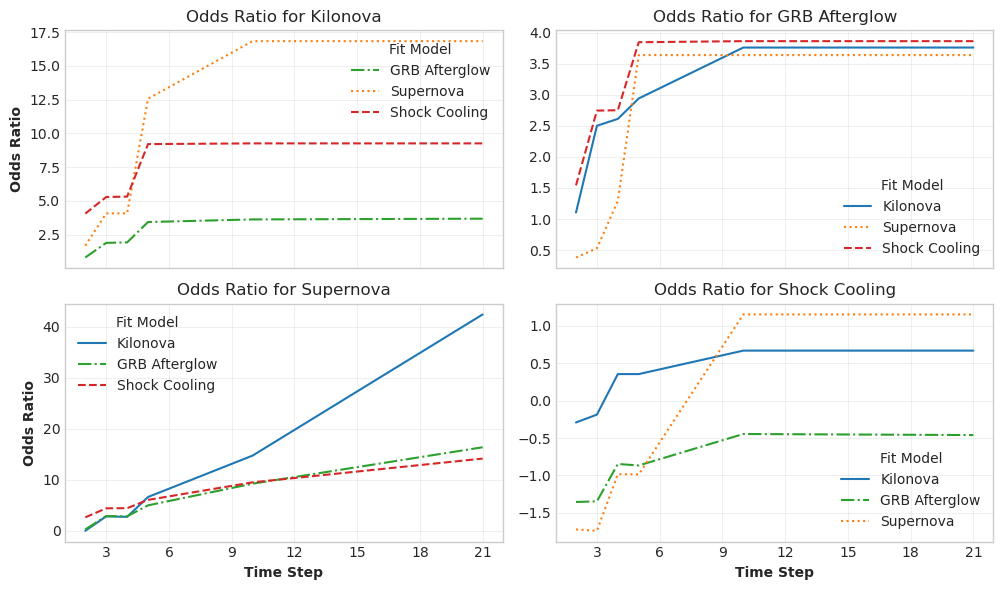

In [199]:
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings(action='once')
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
plt.style.use('seaborn-whitegrid')
plt.style.context(("seaborn-colorblind",))
plt.rcParams['axes.labelweight'] = 'bold'


df = pd.read_csv('./fit_dataframes/ztf-cadence-10-test-fit_df.csv')
# df21 = pd.read_csv('./fit_dataframes/21-validation-fit_df.csv')
# df = pd.concat([df, df21], ignore_index=True)

model_dict = {'Bu2019lm':'Kilonova', 
              'TrPi2018':'GRB Afterglow',
              'Piro2021':'Shock Cooling',
              'nugent-hyper':'Supernova'}
color_dict = {key: value for key, value in zip(model_dict.keys(), sns.color_palette('colorblind')[0:4])}

current_palette = sns.color_palette(n_colors=len(model_dict)).as_hex()

# Generate a dictionary of colors
color_dict = {model: color for model, color in zip(['Bu2019lm', 'nugent-hyper', 'TrPi2018', 'Piro2021'], current_palette)}

display(df.shape)

grouped_df = df.groupby(['t_max', 'fit_model', 'true_model']).agg({'log_bayes_factor': 'median'}).reset_index()
ls_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['-', '--', '-.', ':'])}
#color_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['blue', 'orange', 'green', 'red'])}

fig, axs = plt.subplots(2, 2, figsize=(10, 6),sharex=True)
axs = axs.flatten()
model_order = ['Bu2019lm', 'TrPi2018', 'nugent-hyper', 'Piro2021']
# for axi, model in enumerate(grouped_df['true_model'].unique()):
for axi, model in enumerate(model_order):
    iter_df = grouped_df[grouped_df['true_model'] == model]
    
    ax = axs[axi]
    for fit_model in model_order:
        if fit_model != model:
            diff_df = grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == fit_model)]
            diff =(grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == model)]['log_bayes_factor'].values[0] - diff_df['log_bayes_factor'] )
            ax.plot(diff_df['t_max'], diff, label=f'{model_dict[fit_model]}', color=color_dict[fit_model], linestyle=ls_dict[fit_model])
            ## plot above using lineplot instead of scatter
            #sns.lineplot(x=diff_df['t_max'], y=diff, label=f'{model_dict[fit_model]}', ax=ax, linestyle=ls_dict[fit_model], df = diff_df, hue='fit_model')

    ax.set_title(f'Odds Ratio for {model_dict[model]}')
    ## grid lines
    ax.grid(True, alpha=0.3)

    ax.legend(title='Fit Model')
axs[0].set_ylabel('Odds Ratio'), axs[2].set_ylabel('Odds Ratio')
axs[2].set_xlabel('Time Step'), axs[3].set_xlabel('Time Step')
# axs[0].set_xlim(2,22)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()


# figpath = Path('./plots/odds_ratios_with21.pdf')
# if not os.path.exists(figpath):
#     plt.savefig(figpath, dpi=300)
# else:
#     input(f'{figpath} already exists. Press enter to overwrite.')
#     plt.savefig(figpath, dpi=300)


<Figure size 1200x800 with 0 Axes>

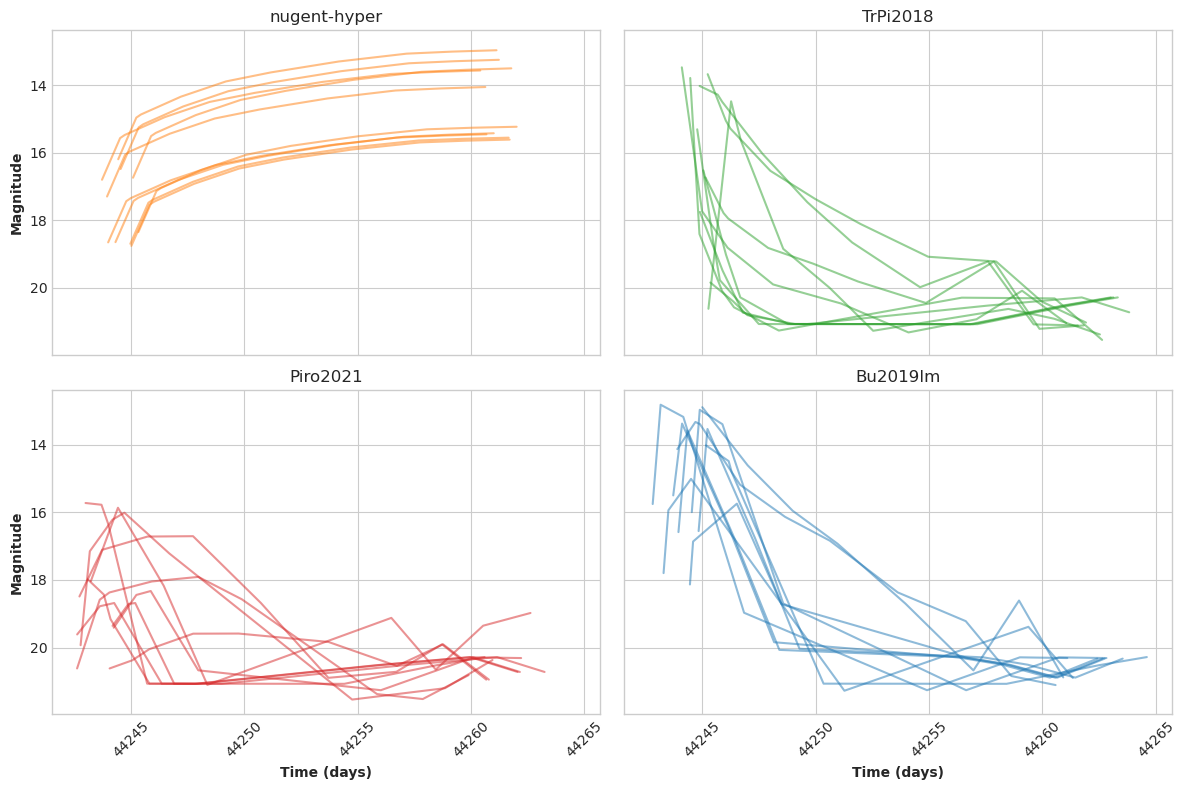

In [186]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = 'injections/ztf-cadence-10-test/'
model_data = {}

for filename in os.listdir(folder_path):
    if filename.startswith("lc_") and filename.endswith(".json"):
        model_name = filename.split("_")[1]
        with open(os.path.join(folder_path, filename), 'r') as file:
            data = json.load(file)
            ztfg_data = data.get("ztfg", [])

        if model_name not in model_data:
            model_data[model_name] = []
        model_data[model_name].append(ztfg_data)

plt.figure(figsize=(12, 8))

## Iterate through model data and plot each lightcurve as a separate line
num_plots = len(model_data)
rows = num_plots // 2 + num_plots % 2  ## Determine the number of rows for subplots
fig, axs = plt.subplots(rows, 2, figsize=(12, 8), sharex=True, sharey=True)
axs = axs.flatten()
for i, (model_name, lc_list) in enumerate(model_data.items()):
    ax = axs[i] #plt.subplot(rows, 2, i + 1, sharex=plt)
    color = color_dict[model_name]
    i_df = [pd.DataFrame(lc_data, columns=["Time", "Value", "Uncertainty"]) for lc_data in lc_list]
    # [sns.lineplot(data=data_frame[data_frame['Time'] <= data_frame['Time'].values[0]+1.5], x="Time", y="Value", alpha=0.3, color='grey', ax=ax) 
    #  for data_frame in i_df]
    # [sns.lineplot(data=data_frame[(data_frame['Time'] >= data_frame['Time'].values[0]+1.5) & (data_frame['Time'] <= data_frame['Time'].values[0]+10)], x="Time", y="Value", alpha=0.5, color=color, ax=ax) 
    #  for data_frame in i_df]
    # [sns.lineplot(data=data_frame[data_frame['Time'] >= data_frame['Time'].values[0]+10], x="Time", y="Value", alpha=0.3, color='grey', ax=ax) 
    #  for data_frame in i_df]
    [sns.lineplot(data=data_frame[data_frame['Time'] >= 0], x="Time", y="Value", alpha=0.5, color=color, ax=ax) 
     for data_frame in i_df]
    ax.set_title(model_name)
    # plt.xlabel("Time")
    # plt.ylabel("Value")
    # ax.invert_yaxis()
    # min_time = min([pd.DataFrame(lc_data, columns=["Time", "Value", "Uncertainty"])["Time"].min() for lc_data in lc_list])
    # ax.set_xlim(min_time+1.5)
    ## make x axis labels rotated by 45 degrees
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
axs[0].invert_yaxis()
axs[0].set_ylabel('Magnitude')
axs[2].set_ylabel('Magnitude')
axs[2].set_xlabel('Time (days)')
axs[3].set_xlabel('Time (days)')
plt.tight_layout()
plt.show()

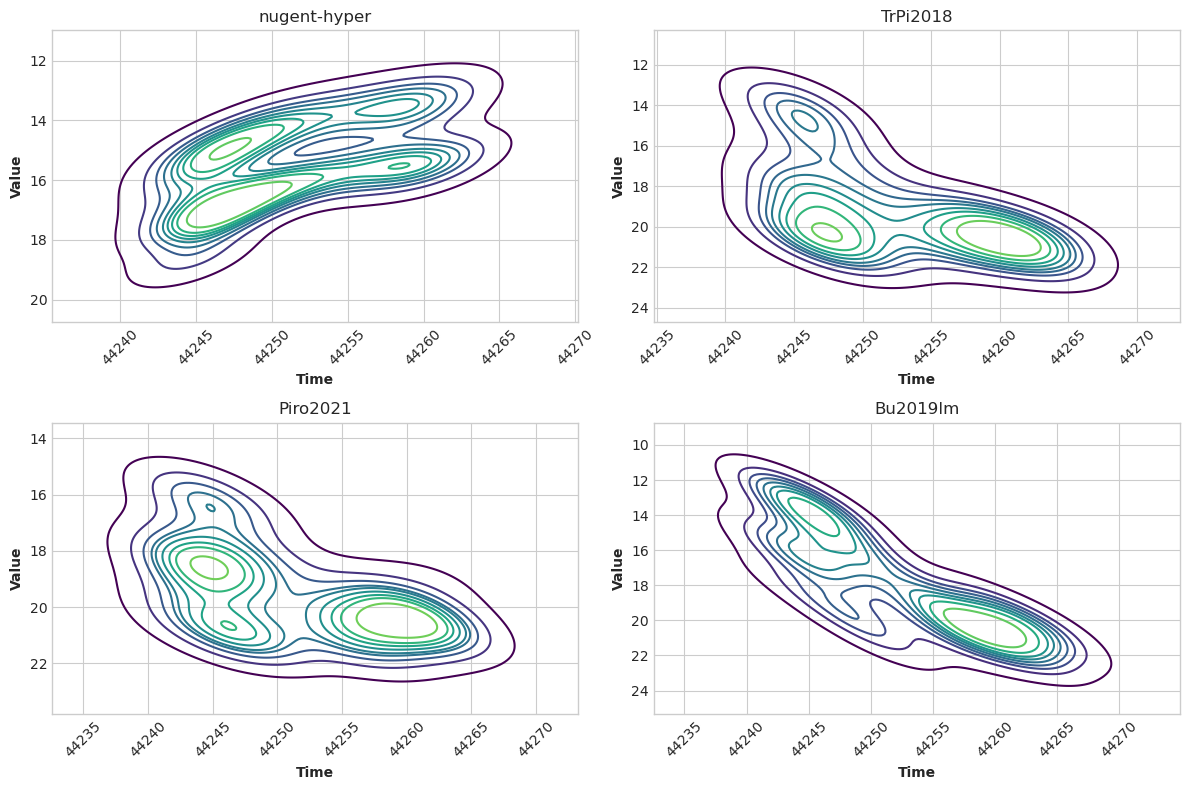

In [165]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

folder_path = 'injections/ztf-cadence-10-test/'
model_data = {}

for filename in os.listdir(folder_path):
    if filename.startswith("lc_") and filename.endswith(".json"):
        model_name = filename.split("_")[1]
        with open(os.path.join(folder_path, filename), 'r') as file:
            data = json.load(file)
            ztfg_data = data.get("ztfg", [])

        if model_name not in model_data:
            model_data[model_name] = []
        model_data[model_name].extend(ztfg_data)  # Extend instead of append

plt.figure(figsize=(12, 8))

# Determine the number of rows for subplots
num_plots = len(model_data)
rows = num_plots // 2 + num_plots % 2

for i, (model_name, lc_list) in enumerate(model_data.items()):
    ax = plt.subplot(rows, 2, i + 1)
    color = color_dict[model_name]

    # Create a Pandas DataFrame for the combined data for each model
    combined_df = pd.DataFrame(lc_list, columns=["Time", "Value", "Uncertainty"])

    # Use Seaborn's KDE plot to visualize the density
    sns.kdeplot(data=combined_df, x="Time", y="Value", cmap="viridis", fill=False, color=color, levels=10)

    plt.title(model_name)
    plt.xlabel("Time")
    plt.ylabel("Value")

    ax.invert_yaxis()

    # Make x-axis labels rotated by 45 degrees
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

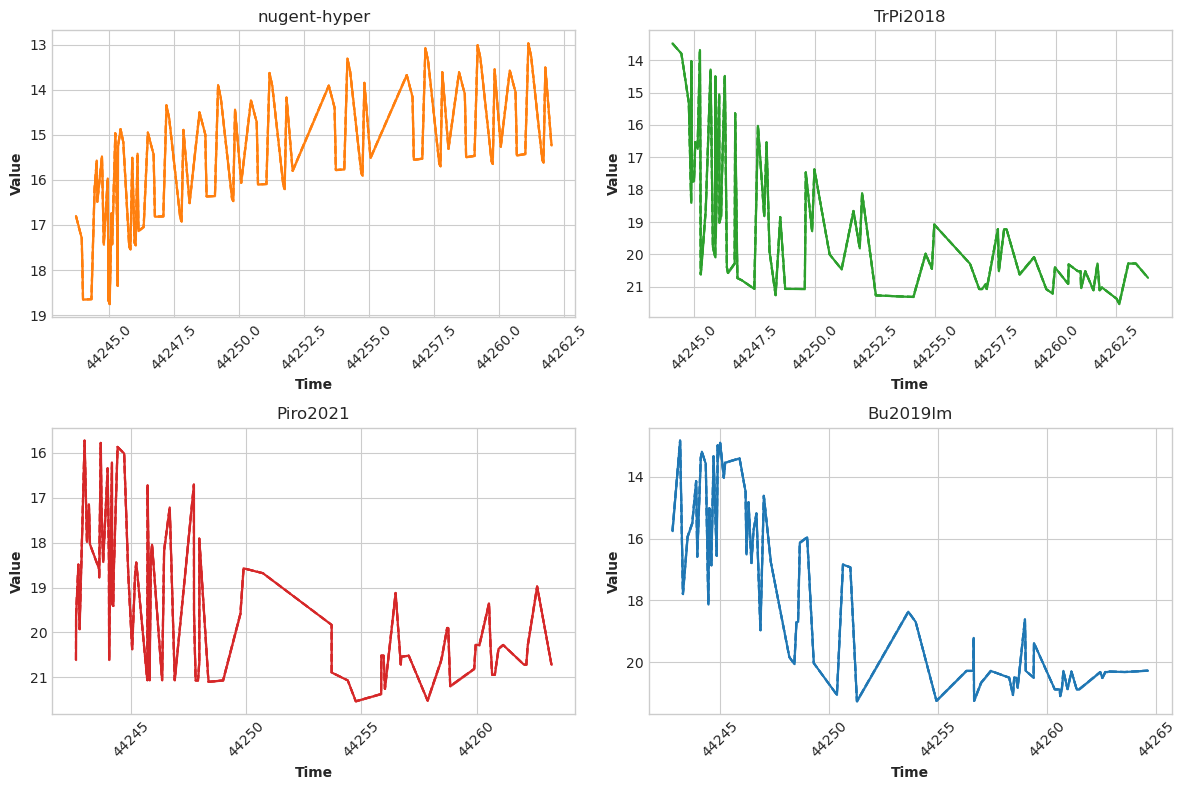

In [172]:
plt.figure(figsize=(12, 8))

# Determine the number of rows for subplots
num_plots = len(model_data)
rows = num_plots // 2 + num_plots % 2

for i, (model_name, lc_list) in enumerate(model_data.items()):
    ax = plt.subplot(rows, 2, i + 1)
    color = color_dict[model_name]

    # Create a Pandas DataFrame for the combined data for each model
    combined_df = pd.DataFrame(lc_list, columns=["Time", "Value", "Uncertainty"])

    # Calculate the median and quartiles for the light curves
    median_lc = combined_df.groupby("Time")["Value"].quantile(0.50)
    q1 = combined_df.groupby("Time")["Value"].quantile(0.1)
    q3 = combined_df.groupby("Time")["Value"].quantile(0.99)

    # Plot the median light curve
    ax.plot(median_lc.index, median_lc.values, color=color, label="Median")
    ax.plot(median_lc.index, q1, color=color, linestyle="--", label="25%")
    ax.plot(median_lc.index, q3, color=color, linestyle="--", label="75%")

    # Shade the area between quartiles
    ax.fill_between(median_lc.index, q1, q3, color=color, alpha=0.5, label="IQR (25%-75%)")

    plt.title(model_name)
    plt.xlabel("Time")
    plt.ylabel("Value")
    ax.invert_yaxis()

    # Make x-axis labels rotated by 45 degrees
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

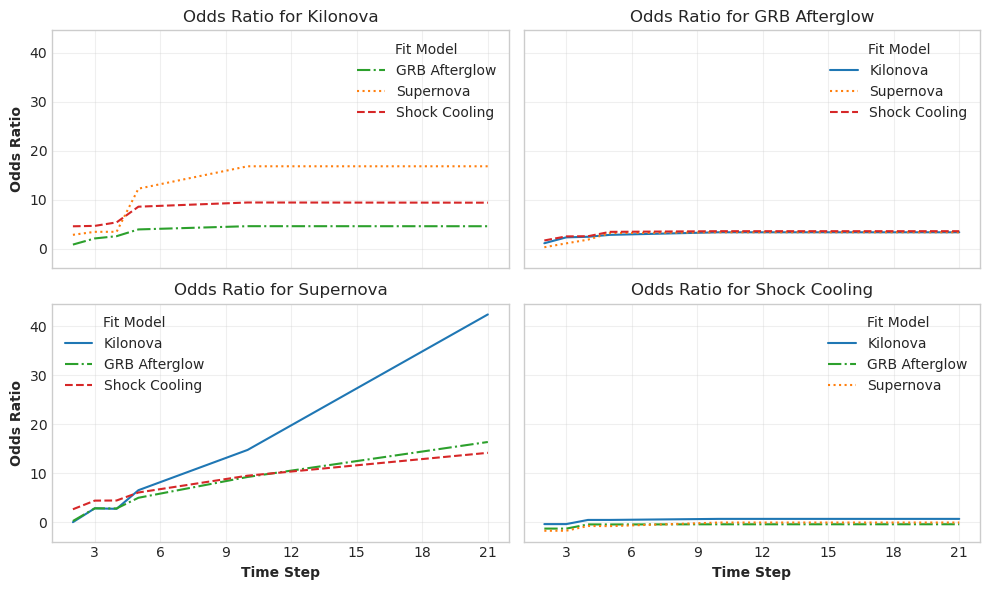

In [201]:
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import warnings
warnings.filterwarnings(action='once')
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
plt.style.use('seaborn-whitegrid')
plt.style.context(("seaborn-colorblind",))
plt.rcParams['axes.labelweight'] = 'bold'


df = pd.read_csv('./fit_dataframes/model-recovery-ignore-first-fit_df.csv')
df = pd.read_csv('./fit_dataframes/ztf-cadence-10-test-fit_df.csv')
# df21 = pd.read_csv('./fit_dataframes/21-validation-fit_df.csv')
# df = pd.concat([df, df21], ignore_index=True)
# display(df)

model_dict = {'Bu2019lm':'Kilonova', 
              'TrPi2018':'GRB Afterglow',
              'Piro2021':'Shock Cooling',
              'nugent-hyper':'Supernova'}
color_dict = {key: value for key, value in zip(model_dict.keys(), sns.color_palette('colorblind')[0:4])}

current_palette = sns.color_palette(n_colors=len(model_dict)).as_hex()

# Generate a dictionary of colors
color_dict = {model: color for model, color in zip(['Bu2019lm', 'nugent-hyper', 'TrPi2018', 'Piro2021'], current_palette)}

# Calculate the odds ratios for each combination and then take the median

df['odds_ratio'] = np.nan
for lightcurve in df['lightcurve'].unique():
    lc_df = df[df['lightcurve'] == lightcurve]
    for row in lc_df.index:
        true_model = lc_df.loc[row, 'true_model']
        fit_model = lc_df.loc[row, 'fit_model']
        if true_model == fit_model:
            df.loc[row, 'odds_ratio'] = np.NaN
        else:
            df.loc[row, 'odds_ratio'] = lc_df[lc_df['fit_model'] == true_model]['log_bayes_factor'].iloc[0] - lc_df.loc[row, 'log_bayes_factor']
# display(df['odds_ratio'].describe())

grouped_df = df.groupby(['t_max', 'fit_model', 'true_model']).agg({'odds_ratio': 'median'}).reset_index()
ls_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['-', '--', '-.', ':'])}
#color_dict = {model:value for model, value in zip(grouped_df['fit_model'].unique(), ['blue', 'orange', 'green', 'red'])}

fig, axs = plt.subplots(2, 2, figsize=(10, 6),sharex=True, sharey=True)
axs = axs.flatten()
model_order = ['Bu2019lm', 'TrPi2018', 'nugent-hyper', 'Piro2021']
# for axi, model in enumerate(grouped_df['true_model'].unique()):
for axi, model in enumerate(model_order):
    # print('\n\ntrue model', model)
    iter_df = grouped_df[grouped_df['true_model'] == model]
    ax = axs[axi]
    for fit_model in model_order:
        if fit_model != model:
            # print('fit model', fit_model)
            diff_df = grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == fit_model)]
            # display(diff_df['odds_ratio'].describe())
            # diff =(grouped_df[(grouped_df['true_model'] == model) & (grouped_df['fit_model'] == model)]['log_bayes_factor'].values[0] - diff_df['log_bayes_factor'] )
            ax.plot(diff_df['t_max'], diff_df['odds_ratio'], label=f'{model_dict[fit_model]}', color=color_dict[fit_model], linestyle=ls_dict[fit_model])
            ## plot above using lineplot instead of scatter
            #sns.lineplot(x=diff_df['t_max'], y=diff, label=f'{model_dict[fit_model]}', ax=ax, linestyle=ls_dict[fit_model], df = diff_df, hue='fit_model')

    ax.set_title(f'Odds Ratio for {model_dict[model]}')
    ## grid lines
    ax.grid(True, alpha=0.3)

    ax.legend(title='Fit Model')
axs[0].set_ylabel('Odds Ratio'), axs[2].set_ylabel('Odds Ratio')
axs[2].set_xlabel('Time Step'), axs[3].set_xlabel('Time Step')
# axs[0].set_xlim(2,22)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()

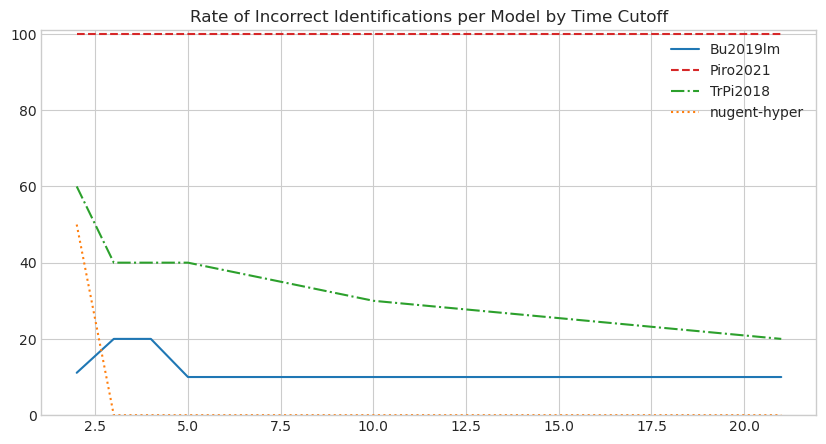

In [202]:
lowest_bayes = []
for lightcurve in  df['lightcurve'].unique():
    for tmax in df[df['lightcurve'] == lightcurve]['t_max'].unique():
        iterative_df = df[(df['lightcurve'] == lightcurve) & (df['t_max'] == tmax)]
        lowest_bf_row = iterative_df[iterative_df['log_bayes_factor'].abs() == iterative_df['log_bayes_factor'].abs().min()].squeeze()
        lowest_bayes.append(lowest_bf_row )

lbf_df = pd.DataFrame(lowest_bayes)     


second_lowest_bayes = []
for lightcurve in df['lightcurve'].unique():
    for tmax in df[df['lightcurve'] == lightcurve]['t_max'].unique():
        iterative_df = df[(df['lightcurve'] == lightcurve) & (df['t_max'] == tmax)]
        second_lowest_bf_row = iterative_df[iterative_df['log_bayes_factor'].abs() == iterative_df['log_bayes_factor'].abs().sort_values().unique()[1]].squeeze()
        second_lowest_bayes.append(second_lowest_bf_row )
scnd_lbf_df = pd.DataFrame(second_lowest_bayes)

## plot the number of incorrect idenfications per model, grouped by t_max (x-axis)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for model in lbf_df['true_model'].unique():
    model_df = lbf_df[(lbf_df['true_model'] == model)]
    ## count number of incorrect identifications per t_max per model
    incorrect_identifications = []
    for tmax in sorted(model_df['t_max'].unique()):
        tmax_df = model_df[model_df['t_max'] == tmax]
        incorrect_identifications.append(len(tmax_df[tmax_df['fit_model'] != model]) / len(tmax_df)*100)
    ax.plot(sorted(model_df['t_max'].unique()), incorrect_identifications, label=model, linestyle=ls_dict[model], color=color_dict[model])
    ax.legend()
    ax.set_ylim(0, 101)
ax.set_title('Rate of Incorrect Identifications per Model by Time Cutoff')
plt.show()


## from lbf_df, find percentage per model of incorrect identifications, grouped by t_max. there are 100 lightcurves for each model

# for tmax in sorted(lbf_df['t_max'].unique()):
#     print(f'\nFor t_max: {tmax}')
#     for model in lbf_df['true_model'].unique():
#         model_df = lbf_df[(lbf_df['true_model'] == model) & (lbf_df['t_max'] == tmax)]
#         print(f'For true model: {model}, the percentage of incorrect identifications is: {round(len(model_df[model_df["fit_model"] != model]) / len(model_df)*100,1)}')

In [176]:
lbf_df

,Unnamed: 0,lightcurve,true_model,lightcurve_path,true_params,true_lightcurve,fit_model,fit_path,t_max,residual,log_likelihood,log_prior,log_bayes_factor,best_fit_params,best_fit_lightcurve,odds_ratio
0,0,Bu2019lm_00000,Bu2019lm,/home/tbarna/dsmma_kn_23/injections/ztf-cadenc...,"{'simulation_id': 0, 'luminosity_distance': 6....","{'sample_times': {0: 0.1, 1: 0.49, 2: 2.58, 3:...",Bu2019lm,/expanse/lustre/projects/umn131/tbarna/ztf-cad...,3.0,34.699666,-1.845789,-9.556423,-3.404353,"{'luminosity_distance': 7.893059683363179, 'KN...","{'ztfg': {0: 17.373262328839594, 1: 13.6400922...",NaN
4,4,Bu2019lm_00000,Bu2019lm,/home/tbarna/dsmma_kn_23/injections/ztf-cadenc...,"{'simulation_id': 0, 'luminosity_distance': 6....","{'sample_times': {0: 0.1, 1: 0.49, 2: 2.58, 3:...",Bu2019lm,/expanse/lustre/projects/umn131/tbarna/ztf-cad...,4.0,40.341965,-1.845800,-12.147170,-3.408937,"{'luminosity_distance': 5.209158441460984, 'KN...","{'ztfg': {0: 17.61603570853513, 1: 13.59884679...",NaN
8,8,Bu2019lm_00000,Bu2019lm,/home/tbarna/dsmma_kn_23/injections/ztf-cadenc...,"{'simulation_id': 0, 'luminosity_distance': 6....","{'sample_times': {0: 0.1, 1: 0.49, 2: 2.58, 3:...",Bu2019lm,/expanse/lustre/projects/umn131/tbarna/ztf-cad...,5.0,96.037676,-2.774001,-10.140031,-4.866597,"{'luminosity_distance': 6.868415120874494, 'KN...","{'ztfg': {0: 16.996353965202616, 1: 13.4834989...",NaN
12,12,Bu2019lm_00000,Bu2019lm,/home/tbarna/dsmma_kn_23/injections/ztf-cadenc...,"{'simulation_id': 0, 'luminosity_distance': 6....","{'sample_times': {0: 0.1, 1: 0.49, 2: 2.58, 3:...",Bu2019lm,/expanse/lustre/projects/umn131/tbarna/ztf-cad...,10.0,92.326388,-2.782195,-9.998824,-4.886814,"{'luminosity_distance': 5.87993563789098, 'KNp...","{'ztfg': {0: 16.82747690544567, 1: 13.45460163...",NaN
16,16,Bu2019lm_00000,Bu2019lm,/home/tbarna/dsmma_kn_23/injections/ztf-cadenc...,"{'simulation_id': 0, 'luminosity_distance': 6....","{'sample_times': {0: 0.1, 1: 0.49, 2: 2.58, 3:...",Bu2019lm,/expanse/lustre/projects/umn131/tbarna/ztf-cad...,21.0,46.163194,-2.782195,-9.998824,-4.886814,"{'luminosity_distance': 5.87993563789098, 'KNp...","{'ztfg': {0: 16.82747690544567, 1: 13.45460163...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783,783,nugent-hyper_00009,nugent-hyper,/home/tbarna/dsmma_kn_23/injections/ztf-cadenc...,"{'simulation_id': 0, 'luminosity_distance': 19...","{'sample_times': {0: 0.1, 1: 0.9, 2: 1.1, 3: 2...",nugent-hyper,/expanse/lustre/projects/umn131/tbarna/ztf-cad...,3.0,19.676830,-2.757832,-7.313220,-4.994449,"{'luminosity_distance': 201.91492256324736, 't...","{'ztfg': {0: 20.157259139017686, 1: 18.2118810...",NaN
787,787,nugent-hyper_00009,nugent-hyper,/home/tbarna/dsmma_kn_23/injections/ztf-cadenc...,"{'simulation_id': 0, 'luminosity_distance': 19...","{'sample_times': {0: 0.1, 1: 0.9, 2: 1.1, 3: 2...",nugent-hyper,/expanse/lustre/projects/umn131/tbarna/ztf-cad...,4.0,52.366815,-2.757811,-7.313220,-4.952849,"{'luminosity_distance': 200.77741100724052, 't...","{'ztfg': {0: 20.149180942920676, 1: 18.2038028...",NaN
791,791,nugent-hyper_00009,nugent-hyper,/home/tbarna/dsmma_kn_23/injections/ztf-cadenc...,"{'simulation_id': 0, 'luminosity_distance': 19...","{'sample_times': {0: 0.1, 1: 0.9, 2: 1.1, 3: 2...",nugent-hyper,/expanse/lustre/projects/umn131/tbarna/ztf-cad...,5.0,45.646278,-3.677258,-7.313220,-6.101329,"{'luminosity_distance': 174.0549352827102, 'ti...","{'ztfg': {0: 20.105761323338893, 1: 18.1603831...",NaN
795,795,nugent-hyper_00009,nugent-hyper,/home/tbarna/dsmma_kn_23/injections/ztf-cadenc...,"{'simulation_id': 0, 'luminosity_distance': 19...","{'sample_times': {0: 0.1, 1: 0.9, 2: 1.1, 3: 2...",nugent-hyper,/expanse/lustre/projects/umn131/tbarna/ztf-cad...,10.0,64.511954,-5.515809,-7.313220,-8.118389,"{'luminosity_distance': 181.3879352465907, 'ti...","{'ztfg': {0: 20.086190604568575, 1: 18.1408124...",NaN


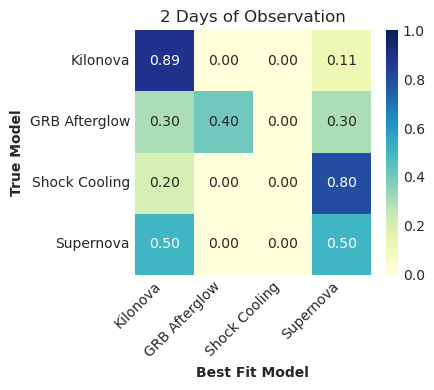

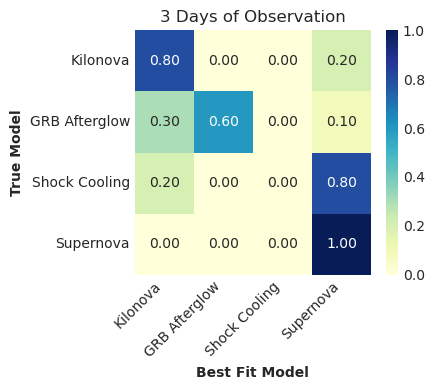

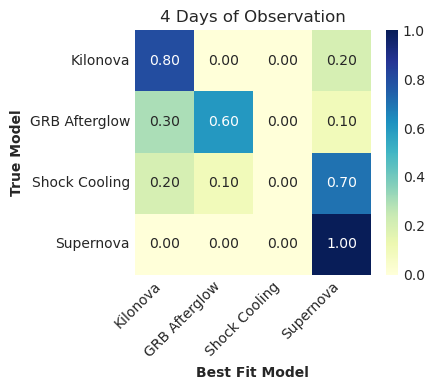

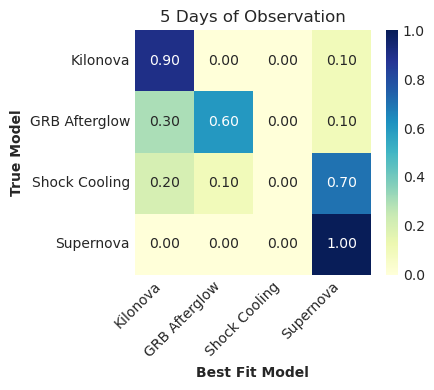

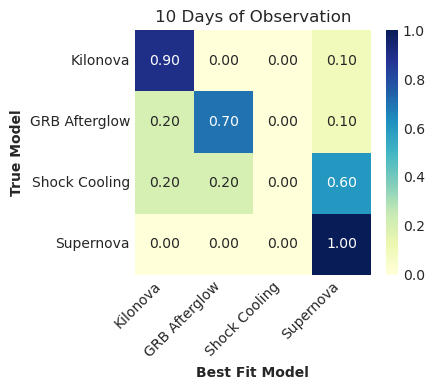

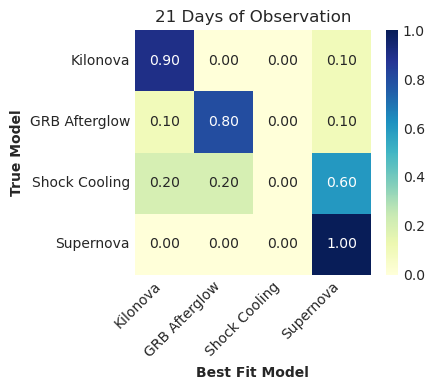

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

model_dict = {
    'Bu2019lm': 'Kilonova',
    'TrPi2018': 'GRB Afterglow',
    'Piro2021': 'Shock Cooling',
    'nugent-hyper': 'Supernova'
}

for tmax in sorted(lbf_df['t_max'].unique()):
# for tmax in sorted([21]):
    try:
        tmax_df = lbf_df[lbf_df['t_max'] == tmax]
        
        
        # Create the heatmap data and replace the index/column names using model_dict
        heatmap_data = tmax_df.groupby(['true_model', 'fit_model']).size().unstack().fillna(0)
        heatmap_data = heatmap_data.apply(lambda x: x / x.sum(), axis=1)
        heatmap_data = heatmap_data.reindex(index=model_dict.keys(), columns=model_dict.keys(), fill_value=0)
        heatmap_data.rename(index=model_dict, columns=model_dict, inplace=True)

        # Create the heatmap
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 4))
        sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu",  norm=Normalize(vmin=0, vmax=1), ax=ax)

        # Set the title for the axes
        ax.set_title(f'{int(tmax)} Days of Observation')

        # Set the new labels for the axes
        ax.set_xticklabels(heatmap_data.columns, rotation=45, horizontalalignment='right')
        ax.set_yticklabels(heatmap_data.index, rotation=0)
        ax.set_xlabel('Best Fit Model')
        ax.set_ylabel('True Model')
        
        fig.tight_layout()
        plt.show()
    except:
        continue


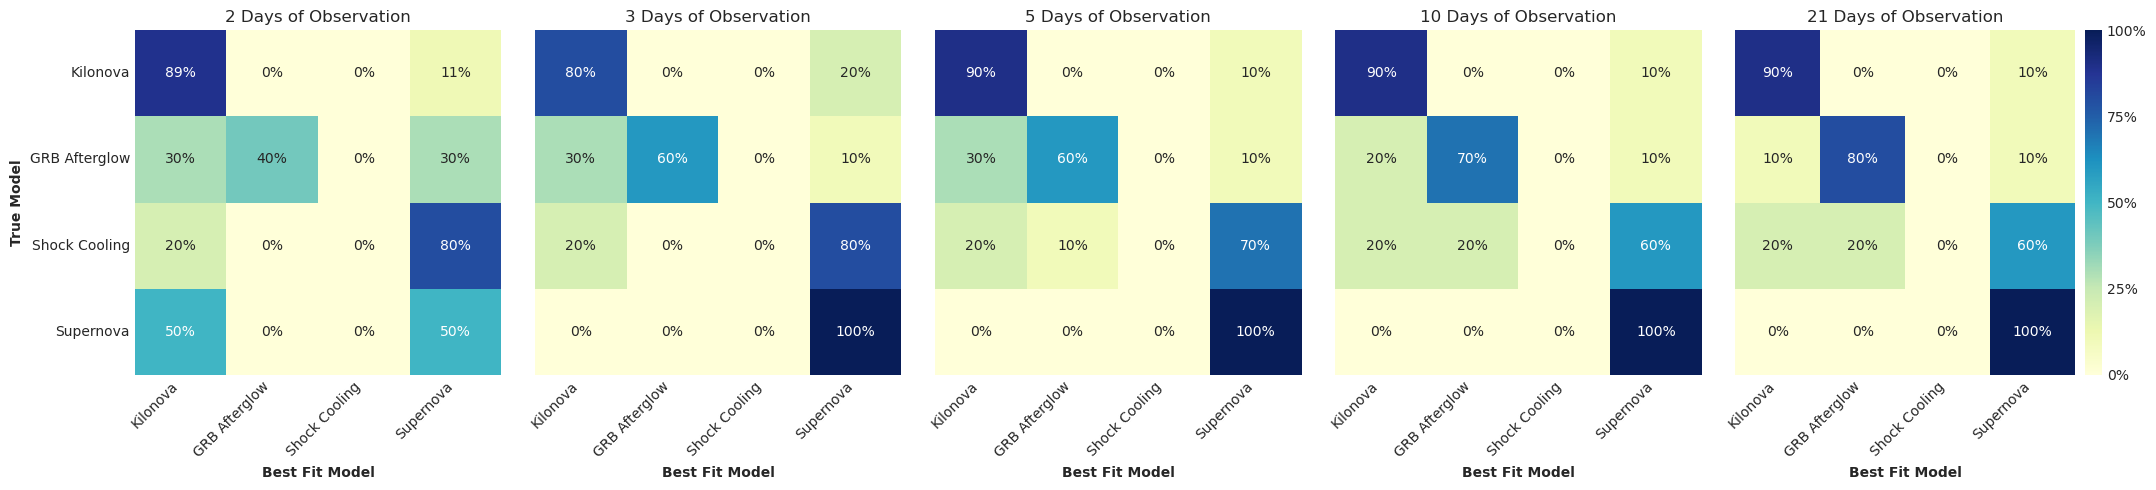

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
from pathlib import Path

model_dict = {
    'Bu2019lm': 'Kilonova',
    'TrPi2018': 'GRB Afterglow',
    'Piro2021': 'Shock Cooling',
    'nugent-hyper': 'Supernova'
}


tmax_array = [2, 3, 5, 10, 21]
fig, axes = plt.subplots(1, len(tmax_array), figsize=(4.333*len(tmax_array), 5), gridspec_kw={'width_ratios': [1]*len(tmax_array)})
all_model_combinations = [(true, fit) for true in model_dict.keys() for fit in model_dict.keys()]

## Iterate over the sorted unique values of t_max and create a subplot for each
for i, tmax in enumerate(sorted(tmax_array)):
    tmax_df = lbf_df[lbf_df['t_max'] == tmax]
    heatmap_data = tmax_df.groupby(['true_model', 'fit_model']).size().unstack().fillna(0)
    heatmap_data = heatmap_data.reindex(index=model_dict.keys(), columns=model_dict.keys(), fill_value=0)
    heatmap_data = heatmap_data.div(heatmap_data.sum(axis=1), axis=0).multiply(100)
    heatmap_data.rename(index=model_dict, columns=model_dict, inplace=True)

    ## Generate annotation data with percentage signs
    annotations = heatmap_data.applymap("{:.0f}%".format)

    ax = axes[i]
    sns.heatmap(heatmap_data, annot=annotations, fmt="", cmap="YlGnBu", norm=Normalize(vmin=0, vmax=100), ax=ax,
                cbar=i == len(tmax_array) - 1,
                cbar_ax=None if i != len(tmax_array) - 1 else make_axes_locatable(axes[i]).append_axes("right", size="5%", pad=0.1))

    ax.set_title(f'{int(tmax)} Days of Observation')
    ax.set_xticklabels(heatmap_data.columns, rotation=45, horizontalalignment='right')
    ax.set_xlabel('Best Fit Model')

    if i == 0:
        ax.set_yticklabels(heatmap_data.index, rotation=0)
        ax.set_ylabel('True Model')
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')

cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75, 100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
fig.tight_layout()

figpath = Path('./plots/conf_matrix_combined.pdf')
if not os.path.exists(figpath):
    plt.savefig('./plots/conf_matrix_combined.pdf', dpi=300)
else:
    input(f'{figpath} already exists. Press enter to overwrite.')
    plt.savefig('./plots/conf_matrix_combined.pdf', dpi=300)


In [198]:
scnd_lbf_df[scnd_lbf_df['true_model']=='Piro2021']
p21_lbf_df = lbf_df[lbf_df['true_model']=='Piro2021']
p21_scnd_lbf_df = scnd_lbf_df[scnd_lbf_df['true_model']=='Piro2021']
for tmax in sorted(p21_scnd_lbf_df['t_max'].unique()):
    iter_df = p21_scnd_lbf_df[p21_scnd_lbf_df['t_max'] == tmax]
    ## count how many per timestep have fit_model == true_model
    print(f'For t_max: {tmax}, the percentage of identifications where Piro2021 is the second best model is: {round(len(iter_df[iter_df["fit_model"] == iter_df["true_model"]]) / len(iter_df)*100,1)}')

For t_max: 3.0, the percentage of identifications where Piro2021 is the second best model is: 0.0
For t_max: 4.0, the percentage of identifications where Piro2021 is the second best model is: 0.0
For t_max: 5.0, the percentage of identifications where Piro2021 is the second best model is: 0.0
For t_max: 10.0, the percentage of identifications where Piro2021 is the second best model is: 0.0
For t_max: 21.0, the percentage of identifications where Piro2021 is the second best model is: 0.0


In [100]:
## for each the piro2021 lightcurves in p21_lbf_df and p21_scnd_lbf_df at each timestep where the value of true_model is not Piro2021 in lbf_df, plot the difference between the log_bayes_factor in p21_lbf_df and p21_scnd_lbf_df

for tmax in sorted(p21_scnd_lbf_df['t_max'].unique()):
    iter_first_df = p21_lbf_df[p21_lbf_df['t_max'] == tmax]
    iter_scnd_df = p21_scnd_lbf_df[p21_scnd_lbf_df['t_max'] == tmax]
    ## calculate median difference in log_bayes_factor for each lightcurve
    odds_ratio = []
    first_bf = []
    first_model = []
    scnd_bf = []
    scnd_model = []
    odds_ratio_lcs = []
    num_correct = 0
    num_total = 0
    num_scnd_correct = 0
    print(f'\nFor t_max = {tmax}:')
    for lc in iter_first_df['lightcurve'].unique():
        first_df = iter_first_df[iter_first_df['lightcurve'] == lc]
        scnd_df = iter_scnd_df[iter_scnd_df['lightcurve'] == lc]
        num_total += 1
        if scnd_df['fit_model'].values[0] == 'Piro2021':
            num_scnd_correct += 1
        if first_df['fit_model'].values[0] == 'Piro2021':
            # print('for lightcurve: ', lc, 'the first best model is Piro2021')
            num_correct += 1
            continue
        elif scnd_df['fit_model'].values[0] != 'Piro2021':
            continue
        else:
            # print(first_df['fit_model'].values[0])
            first_bf.append(first_df['log_bayes_factor'].values[0])
            scnd_bf.append(scnd_df['log_bayes_factor'].values[0])
            first_model.append(first_df['fit_model'].values[0])
            scnd_model.append(scnd_df['fit_model'].values[0])
            odds_ratio_lcs.append(lc)
            odds_ratio.append(first_df['log_bayes_factor'].values[0] - scnd_df['log_bayes_factor'].values[0])
    
    print(f'Median odds ratio: {np.median(odds_ratio)}')
    #print('number of lightcurves with positive odds ratio: ', len([i for i in odds_ratio if i > 0]))
    print('number of correct identifications: ', num_correct)
    print('number where Piro2021 is the second best model: ', num_scnd_correct)
    print('number of total lightcurves: ', num_total)
    print('percent of misidentifications where the second best model is Piro2021: ', round(num_scnd_correct / (num_total-num_correct) * 100, 1))
    ## print models for which the odds ratio is negative
    # print('models for which the odds ratio is negative: ', [model for model in scnd_model if model != 'Piro2021'])


For t_max = 3.0:
Median odds ratio: nan
number of correct identifications:  0
number where Piro2021 is the second best model:  0
number of total lightcurves:  81
percent of misidentifications where the second best model is Piro2021:  0.0

For t_max = 4.0:
Median odds ratio: 0.8037707217466412
number of correct identifications:  0
number where Piro2021 is the second best model:  2
number of total lightcurves:  81
percent of misidentifications where the second best model is Piro2021:  2.5

For t_max = 5.0:
Median odds ratio: 1.356714489677822
number of correct identifications:  0
number where Piro2021 is the second best model:  3
number of total lightcurves:  81
percent of misidentifications where the second best model is Piro2021:  3.7

For t_max = 6.0:
Median odds ratio: 1.309374163482575
number of correct identifications:  0
number where Piro2021 is the second best model:  7
number of total lightcurves:  81
percent of misidentifications where the second best model is Piro2021:  8.6



/home/tbarna/anaconda3/envs/nmma_dev/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tbarna/anaconda3/envs/nmma_dev/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Median odds ratio: 1.1299615909424432
number of correct identifications:  0
number where Piro2021 is the second best model:  9
number of total lightcurves:  81
percent of misidentifications where the second best model is Piro2021:  11.1

For t_max = 8.0:
Median odds ratio: 0.8462828348790437
number of correct identifications:  0
number where Piro2021 is the second best model:  10
number of total lightcurves:  81
percent of misidentifications where the second best model is Piro2021:  12.3

For t_max = 9.0:
Median odds ratio: 0.8382523325860554
number of correct identifications:  3
number where Piro2021 is the second best model:  19
number of total lightcurves:  81
percent of misidentifications where the second best model is Piro2021:  24.4

For t_max = 10.0:
Median odds ratio: 0.6386650782818819
number of correct identifications:  5
number where Piro2021 is the second best model:  20
number of total lightcurves:  81
percent of misidentifications where the second best model is Piro2021: 